In [1]:
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import random
import numpy as np
from typing import Dict, List, Optional, Tuple
import cv2
import base64
import imageio
from collections import defaultdict
from tqdm.notebook import tqdm
from copy import deepcopy
from pprint import pprint
from PIL import Image
from sklearn.model_selection import train_test_split
import os

import torch
from torch import optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torchvision.utils import make_grid

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Training on',DEVICE)

Training on cuda


In [2]:
DATASET_PATH ="/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"
ATTRIBUTES_PATH = "/kaggle/input/lfw-attributes/lfw_attributes.txt"

# Explore the data

In [3]:
dataset = []
for path in glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg")):
    person = path.split("/")[-2]
    dataset.append({"person":person, "path": path})
    
dataset = pd.DataFrame(dataset)
#too much Bush
dataset = dataset.groupby("person").filter(lambda x: len(x) < 25 )
dataset.head(10)

,person,path
0,Tyler_Hamilton,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
1,Tyler_Hamilton,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
2,Bernard_Siegel,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
3,Blythe_Danner,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
4,Blythe_Danner,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
5,Gene_Robinson,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
6,Gene_Robinson,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
7,Gene_Robinson,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
8,Gene_Robinson,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
9,Gene_Robinson,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...


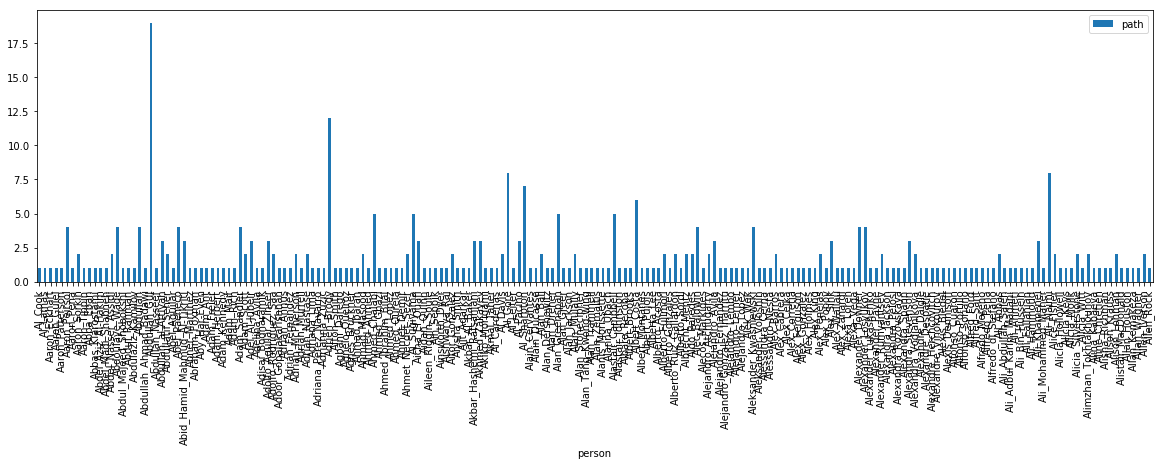

In [4]:
dataset.groupby("person").count()[:200].plot(kind='bar', figsize=(20,5))

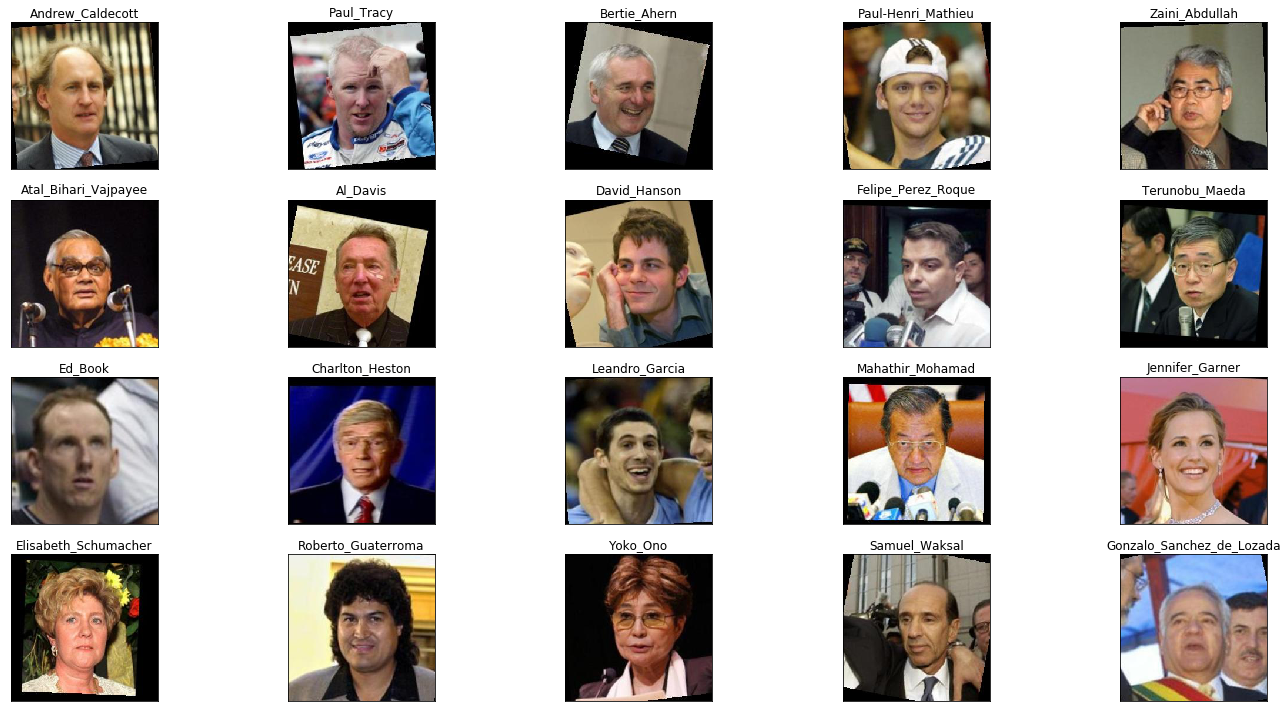

In [5]:
plt.figure(figsize=(20,10))
for i in range(20):
    idx = random.randint(0, len(dataset))
    img = plt.imread(dataset.path.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(dataset.person.iloc[idx])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

# Prepare the dataset

In [6]:
def fetch_dataset(dx=80,dy=80, dimx=32,dimy=32):
    
    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])
    
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"
    
    all_photos = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx,dimy])) )

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs

In [7]:
data, attrs = fetch_dataset(dimx=32,dimy=32)

#32,32
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]

N_CHANNELS = 3

data = np.array(data / 255, dtype='float32')
X_train, X_val = train_test_split(data, test_size=0.2, random_state=42)

X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)

In [8]:
X_train.shape, X_val.shape

(torch.Size([10514, 32, 32, 3]), torch.Size([2629, 32, 32, 3]))

# ResNetVAE

In [9]:
def get_normal_KL(
    mean_1: torch.Tensor,
    log_std_1: torch.Tensor,
    mean_2: Optional[torch.Tensor] = None,
    log_std_2: Optional[torch.Tensor] = None,
) -> torch.Tensor:
    """
    :Parameters:
    mean_1: means of normal distributions
    log_std_1 : standard deviations of normal distributions
    mean_2: means of normal distributions
    log_std_2 : standard deviations of normal distributions
    :Outputs:
    kl divergence of the normal distributions and normal distributions
    """
    if mean_2 is None:
        mean_2 = torch.zeros_like(mean_1)
    if log_std_2 is None:
        log_std_2 = torch.zeros_like(log_std_1)
    assert mean_1.shape == log_std_1.shape == mean_2.shape == log_std_2.shape

    std_1 = torch.exp(log_std_1)
    std_2 = torch.exp(log_std_2)

    kl = log_std_2 - log_std_1 + (std_1 ** 2 + (mean_1 - mean_2) ** 2) / (2 * std_2 ** 2) - 0.5

    return kl

In [10]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, final_relu=True):
        super().__init__()
        self.final_relu = final_relu
        
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=(kernel_size-1)//2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels)
        )

        self.relu2 = nn.ReLU()
        self.alignment_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)

    def forward(self, x):
        sequential_part = self.seq(x)
        residual_part = self.alignment_layer(x)
        result = sequential_part + residual_part

        if self.final_relu:
            result = self.relu2(result)
        return result

In [11]:
class ResNetTransposeBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, final_relu=True):
        super().__init__()
        self.final_relu = final_relu

        padding = (kernel_size - stride) // 2
        self.up_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding=padding, output_padding=0),
            nn.BatchNorm2d(out_channels),
        )
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
        )
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out_upconv = self.up_conv(x)
        out_conv = self.conv(self.relu1(out_upconv))

        result = out_upconv + out_conv

        if self.final_relu:
            result = self.relu2(result)

        return result

In [12]:
class ConvResNetEncoder(nn.Module):
    def __init__(self, input_shape, n_latent):
        super().__init__()
        self.input_shape = input_shape
        self.n_latent = n_latent

        self.resnet_blocks = nn.Sequential(
            ResNetBlock(input_shape[0], 64, kernel_size=3, stride=2),
            ResNetBlock(64, 128, kernel_size=3, stride=2),
            ResNetBlock(128, 256, kernel_size=3, stride=2),
            ResNetBlock(256, 512, kernel_size=3, stride=2),
        )

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512 * 4, 2 * n_latent)

    def forward(self, x):
        x = self.resnet_blocks(x)
        x = self.flatten(x)
        out = self.fc(x)
        mu, log_std = torch.chunk(out, 2, dim=1)

        return mu, log_std


class ConvResNetDecoder(nn.Module):
    def __init__(self, n_latent, output_shape):
        super().__init__()
        self.n_latent = n_latent
        self.output_shape = output_shape
        
        self.fc = nn.Linear(n_latent, 512 * 4)

        self.resnet_transpose_blocks = nn.Sequential(
            ResNetTransposeBlock(512, 256, kernel_size=4, stride=2),
            ResNetTransposeBlock(256, 128, kernel_size=4, stride=2),
            ResNetTransposeBlock(128, 64, kernel_size=4, stride=2),
            ResNetTransposeBlock(64, output_shape[0], kernel_size=4, stride=2, final_relu=False),
        )

    def forward(self, z):
        z = self.fc(z)
        z = z.view(-1, 512, 2, 2)

        out = self.resnet_transpose_blocks(z)
        return out

In [13]:
class ConvVAE(nn.Module):
    def __init__(self, input_shape: tuple, n_latent: int, beta: float = 1) -> None:
        super().__init__()
        assert len(input_shape) == 3

        self.input_shape = input_shape
        self.n_latent = n_latent
        self.beta = beta

        self.init_submodels()

    def init_submodels(self):
        self.encoder = ConvResNetEncoder(self.input_shape, self.n_latent)
        self.decoder = ConvResNetDecoder(self.n_latent, self.input_shape)

    @property
    def device(self):
        return next(self.parameters()).device

    def prior(self, n: int) -> torch.Tensor:
        z = torch.randn(n, self.n_latent, device=self.device)
        z = z.to(self.device)
        return z

    def forward(self, x: torch.Tensor) -> tuple:
        mu_z, log_std_z = self.encoder(x)
        z = mu_z + torch.exp(log_std_z) * self.prior(x.size(0))
        x_recon = self.decoder(z)

        return mu_z, log_std_z, x_recon

    def loss(self, x: torch.Tensor) -> dict:
        mu_z, log_std_z, x_recon = self.forward(x)

        recon_loss = F.mse_loss(x_recon, x)
        kl_loss = get_normal_KL(mu_z, log_std_z).mean()
        elbo_loss = (1 - self.beta) * recon_loss + self.beta * kl_loss

        return {
            "elbo_loss": elbo_loss,
            "recon_loss": recon_loss,
            "kl_loss": kl_loss,
        }

    def sample(self, n: int) -> np.ndarray:
        with torch.no_grad():
            z_samples = self.prior(n)
            x_recon = self.decoder(z_samples)
            samples = torch.clamp(x_recon, -1, 1)

        return samples.cpu().numpy() * 0.5 + 0.5

In [14]:
def train_epoch(
    model: object,
    train_loader: object,
    optimizer: object,
    use_cuda: bool,
    loss_key: str = "total",
) -> defaultdict:
    model.train()

    stats = defaultdict(list)
    for x in train_loader:
        if use_cuda:
            x = x.cuda()
        losses = model.loss(x)
        optimizer.zero_grad()
        losses[loss_key].backward()
        optimizer.step()

        for k, v in losses.items():
            stats[k].append(v.item())

    return stats


def eval_model(model: object, data_loader: object, use_cuda: bool) -> defaultdict:
    model.eval()
    stats = defaultdict(float)
    with torch.no_grad():
        for x in data_loader:
            if use_cuda:
                x = x.cuda()
            losses = model.loss(x)
            for k, v in losses.items():
                stats[k] += v.item() * x.shape[0]

        for k in stats.keys():
            stats[k] /= len(data_loader.dataset)
    return stats


def train_model(
    model: object,
    train_loader: object,
    test_loader: object,
    epochs: int,
    lr: float,
    use_tqdm: bool = False,
    use_cuda: bool = False,
    loss_key: str = "total_loss",
) -> Tuple[dict, dict]:
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = defaultdict(list)
    test_losses = defaultdict(list)
    forrange = tqdm(range(epochs)) if use_tqdm else range(epochs)
    if use_cuda:
        model = model.cuda()

    for epoch in forrange:
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, use_cuda, loss_key)
        test_loss = eval_model(model, test_loader, use_cuda)

        for k in train_loss.keys():
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return dict(train_losses), dict(test_losses)

TICKS_FONT_SIZE = 12
LEGEND_FONT_SIZE = 12
LABEL_FONT_SIZE = 14
TITLE_FONT_SIZE = 16


def plot_training_curves(
    train_losses: Dict[str, np.ndarray],
    test_losses: Dict[str, np.ndarray],
    logscale_y: bool = False,
    logscale_x: bool = False,
) -> None:
    n_train = len(train_losses[list(train_losses.keys())[0]])
    n_test = len(test_losses[list(train_losses.keys())[0]])
    x_train = np.linspace(0, n_test - 1, n_train)
    x_test = np.arange(n_test)

    plt.figure()
    for key, value in train_losses.items():
        plt.plot(x_train, value, label=key + "_train")

    for key, value in test_losses.items():
        plt.plot(x_test, value, label=key + "_test")

    if logscale_y:
        plt.semilogy()

    if logscale_x:
        plt.semilogx()

    plt.legend(fontsize=LEGEND_FONT_SIZE)
    plt.xlabel("Epoch", fontsize=LABEL_FONT_SIZE)
    plt.ylabel("Loss", fontsize=LABEL_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)
    plt.grid()
    plt.show()
    
def show_samples(
    samples: np.ndarray,
    title: str,
    figsize: Optional[Tuple[int, int]] = None,
    nrow: Optional[int] = None,
) -> None:
    if isinstance(samples, np.ndarray):
        samples = torch.FloatTensor(samples)
    if nrow is None:
        nrow = int(np.sqrt(len(samples)))
    grid_samples = make_grid(samples, nrow=nrow)

    grid_img = grid_samples.permute(1, 2, 0)
    if figsize is None:
        figsize = (6, 6)
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.imshow(grid_img)
    plt.axis("off")
    plt.show()



elbo_loss: 0.0448
recon_loss: 0.0384
kl_loss: 0.1027


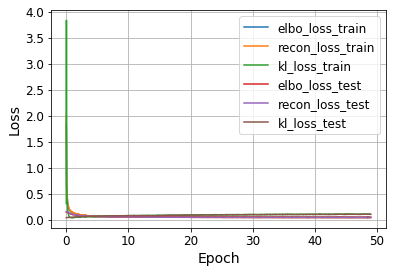

In [15]:
BATCH_SIZE = 256
EPOCHS = 50
LR = 1e-3
N_LATENS = 128
BETA = 0.1
USE_CUDA = True

X_tr = X_train.permute(0, 3, 1, 2)
X_v = X_val.permute(0, 3, 1, 2)

# we center the data, because it helps the model to fit
centered_train_data = X_tr * 2 - 1
centered_test_data = X_v * 2 - 1

train_loader = data_utils.DataLoader(centered_train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = data_utils.DataLoader(centered_test_data, batch_size=BATCH_SIZE, drop_last=True)

model = ConvVAE((3, 32, 32), N_LATENS, BETA)

train_losses, test_losses = train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    lr=LR,
    loss_key="elbo_loss",
    use_tqdm=True,
    use_cuda=USE_CUDA,
)

for key, value in test_losses.items():
    print("{}: {:.4f}".format(key, value[-1]))
plot_training_curves(train_losses, test_losses)

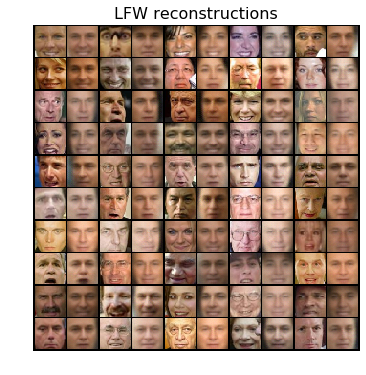

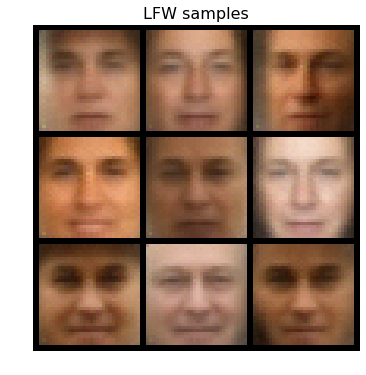

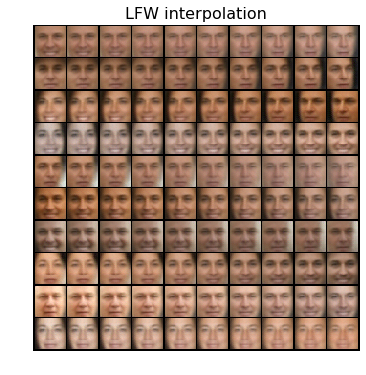

In [16]:
samples = model.sample(9)

x = next(iter(test_loader))[:50]

x = x.to(model.device)

with torch.no_grad():
    z, _ = model.encoder(x)
    x_recon = torch.clamp(model.decoder(z), -1, 1)
reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
reconstructions = reconstructions.cpu().numpy()

x = next(iter(test_loader))[:20]
x = x.to(model.device)
with torch.no_grad():
    z, _ = model.encoder(x)
    z1, z2 = z.chunk(2, dim=0)
    interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
    interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
    interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
interps = interps.cpu().numpy()

show_samples(reconstructions, 'LFW reconstructions')
show_samples(samples, 'LFW samples')
show_samples(interps, 'LFW interpolation')

# Add some attributes

In [17]:
attrs.head()

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.56835,-1.88904,1.7372,-0.929729,-1.4718,-0.19558,-0.835609,-0.351468,-1.01253,-0.719593,...,0.361738,1.16612,-1.16492,-1.13999,-2.37175,-1.29993,-0.414682,-1.1449,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.28218,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.00624408,-0.0304057,-0.480128,0.66676,-0.496559
2,0.997749,-1.36419,-0.157377,-0.756447,-1.89183,-0.871526,-0.862893,0.0314447,-1.34152,-0.0900375,...,1.54974,1.88475,-0.999765,-1.35986,-1.91211,-1.09563,0.915126,-0.572332,0.144262,-0.841231
3,1.12272,-1.9978,1.91614,-2.51421,-2.58007,-1.40424,0.0575511,0.000195882,-1.27351,-1.43146,...,0.567822,-0.176089,1.10812,-1.60094,-3.26461,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.07821,-2.0081,1.67621,-2.27806,-2.65185,-1.34841,0.649089,0.0176564,-1.88911,-1.85721,...,-1.46147,-0.955283,0.119113,-1.12818,-3.16105,0.0826804,-0.439614,-0.359859,-0.760774,-0.410152


In [19]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

In [51]:
smile_beard = attrs.sort_values(by=['No Beard'], ascending=True).loc[:, ['No Beard', 'Smiling']]
no_smile_beard = smile_beard[(smile_beard['Smiling'] < -2) & (smile_beard['No Beard'] < -2)]
no_smile_beard_ids = no_smile_beard.index.values
no_smile_beard_data = data[no_smile_beard_ids]
print(len(no_smile_beard_ids))

3


In [47]:
smile_ids = attrs['Smiling'].sort_values(ascending=False).iloc[100:125].index.values
smile_data = data[smile_ids]

no_smile_ids = attrs['Smiling'].sort_values(ascending=True).head(25).index.values
no_smile_data = data[no_smile_ids]

no_beard_ids = attrs['No Beard'].sort_values(ascending=False).iloc[100:125].index.values
no_beard_data = data[no_beard_ids]

beard_ids = attrs['No Beard'].sort_values(ascending=True).head(25).index.values
beard_data = data[beard_ids]

female_ids = attrs['Male'].sort_values(ascending=True).head(25).index.values
female_data = data[female_ids]

In [49]:
def plot_gallery(images, h, w, n_row=3, n_col=6, with_title=False, titles=[]):
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            if with_title:
                plt.title(titles[i])
            plt.xticks(())
            plt.yticks(())
        except:
            pass

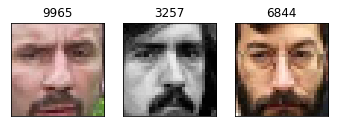

In [52]:
plot_gallery(no_smile_beard_data, IMAGE_H, IMAGE_W, n_row=1, n_col=3, with_title=True, titles=no_smile_beard_ids)

In [53]:
def to_latent(inputs):
    with torch.no_grad():
        inputs = torch.FloatTensor(inputs).permute(0, 3, 1, 2)
        inputs = inputs * 2 - 1
        inputs = inputs.to(DEVICE)
        z, _ = model.encoder(inputs)
        return z

## Shaving and smiling

In [54]:
no_beard_latent = to_latent(no_beard_data).mean(axis=0)
no_smile_latent = to_latent(no_smile_data).mean(axis=0)
female_latent = to_latent(female_data).mean(axis=0)

no_beard_vec = no_beard_latent-no_smile_latent-female_latent

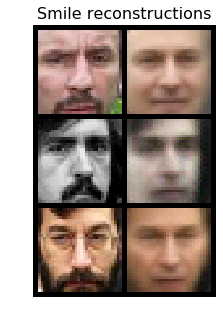

In [59]:
beard_data_tensor = torch.FloatTensor(no_smile_beard_data).permute(0, 3, 1, 2)
beard_data_tensor = beard_data_tensor * 2 - 1
beard_data_tensor = beard_data_tensor.to(DEVICE)

with torch.no_grad():
    z, _ = model.encoder(beard_data_tensor)
    x_recon = torch.clamp(model.decoder(z + no_beard_vec), -1, 1)
reconstructions = torch.stack((beard_data_tensor, x_recon), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
reconstructions = reconstructions.cpu().numpy()

show_samples(reconstructions, 'Smile reconstructions', nrow=2, figsize=(10,5))

So, we can see that reconstructed images do not have beard, but also the smile is tiny (or just there is no smile), what is not so good. The possible reason is model colabse, what is mean that model's learned latent is not as good as we want. This can be fixed by choosen appropriate weights in ELBO loss, or change model capacity.